In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.data.experimental import AUTOTUNE

import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()# label_mode='fine'

train_images = train_images / 255 - 0.5 # normalization
test_images = test_images / 255 - 0.5
print(str(np.min(train_images)) + ', '+ str(np.max(train_images)))

-0.5, 0.5


In [3]:
#train_images = train_images[:10000]
#train_labels = train_labels[:10000]
#test_images = test_images[:1000]
#test_labels = test_labels[:1000]

In [4]:
def get_sparse(labels):
    sparse_labels = np.zeros((labels.shape[0], int(np.max(labels)) + 1))
    for x in range(labels.shape[0]):
        sparse_labels[x, labels[x]] = 1
    return sparse_labels
    
    
train_labels = get_sparse(train_labels)
test_labels = get_sparse(test_labels)

In [5]:
labeled_train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
labeled_test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

### Procesing the images

In [6]:
def augment(img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
    
    #TODO img = tf.keras.preprocessing.image.random_rotation(rg=45, fill_mode='constant', cval=0)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    #crop_size = (tf.random.uniform([1])[0] * 0.25 + 0.75) * ORIGINAL_SIZE 
    #img = tf.image.random_crop(img, size = (crop_size, crop_size, 3)) # zoom in & out. max(zoom_out)=original size
    #img = tf.image.resize(img, size = tf.constant((224, 224)))
    
    img = tf.image.random_flip_left_right(img)
    
    return img, label

In [7]:
train_image_count = tf.data.experimental.cardinality(labeled_train_ds).numpy()
BATCH_SIZE = 128
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()  # Repeat forever
    
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE)

    # dataset fetches batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [8]:
def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
    ds = ds.cache()
        
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [9]:
train_ds = prepare_for_training(labeled_train_ds)
test_ds = prepare_for_testing(labeled_test_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

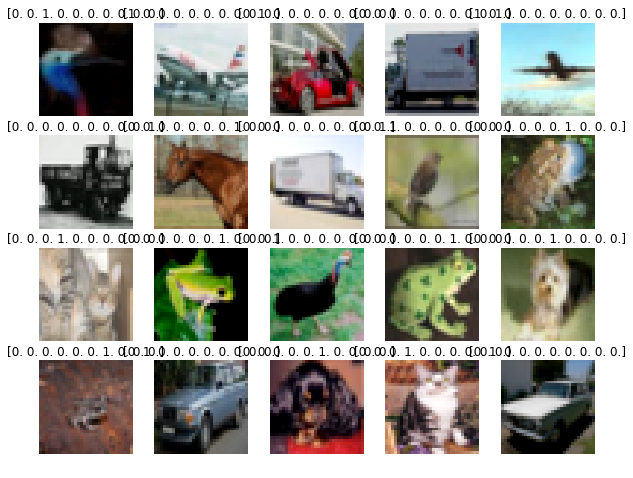

In [10]:
def show_batch(image_batch, label_batch):
    nr_images = 20
    images = []
    with tf.Session().as_default():
        images = image_batch[:nr_images].numpy().astype(float)
    
    plt.figure(figsize=(10,10))
    for n in range(nr_images):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(images[n] + 0.5)
        plt.title(label_batch[n].numpy())
        #plt.title(  CLASS_NAMES[np.nonzero(label_batch[n].numpy())[0]][0])
        plt.axis('off')

def preview_augmentation():
    # we take only 1 to see how the augmentation worked
    #preview_labeled_train_ds = labeled_train_ds.take(1)
    preview_labeled_train_ds = labeled_train_ds
    preview_train_ds = prepare_for_training(preview_labeled_train_ds)

    image_batch, label_batch = next(iter(preview_train_ds))
    show_batch(image_batch, label_batch)

preview_augmentation()

### Preprocessing the images
1. Scaling and croping the images

In [11]:
# TODO At test time, the network makes a prediction by extracting five 224 × 224 patches 
# (the four corner patches and the center patch) as well as their horizontal reflections (hence ten patches in all),
# and averaging the predictions made by the network’s softmax layer on the ten patches

def normalized_init(number_inputs):
    return tf.compat.v1.keras.initializers.RandomNormal(mean=0.0, stddev=1/number_inputs) 

k_init=tf.compat.v1.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
point_one=tf.compat.v2.constant_initializer(value=0.01)

model = keras.Sequential([
    #keras.layers.Conv2D(96, (11, 11), input_shape=(32, 32, 3),  strides=4, activation='relu', 
    #                    bias_initializer='zeros', kernel_initializer=normalized_init(121)),
    #keras.layers.MaxPooling2D(pool_size=3, strides=2),
    
    keras.layers.Conv2D(256, (5, 5), input_shape=(32, 32, 3), activation='relu', bias_initializer='zeros', 
                        kernel_initializer=normalized_init(25)),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    
    keras.layers.Conv2D(384, (3, 3), activation='relu', bias_initializer='zeros', 
                        kernel_initializer=normalized_init(9)),

    # 4th conv. layer
    keras.layers.Conv2D(384, (3, 3), activation='relu', bias_initializer=point_one, 
                        kernel_initializer=normalized_init(9)),

    # TODO: How does the Convolutional layer work?
    # For every convolution from every filter, it connects with a (3,3) window to all 384 previous filters?
    # should it be 9 ? or 9*384?
    keras.layers.Conv2D(256, (3, 3), activation='relu', bias_initializer=point_one, 
                        kernel_initializer=normalized_init(9)),
    
    keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),        
    keras.layers.Dense(4096, activation='relu', bias_initializer=point_one, 
                       # TODO why is smaller number better 216 vs 4096
                       kernel_initializer=normalized_init(216)),
    
    tf.keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(4096, activation='relu', bias_initializer=point_one, 
                       kernel_initializer=normalized_init(100)),
    
    keras.layers.Dense(10, activation='softmax', bias_initializer='zeros', 
                       kernel_initializer=normalized_init(100)) # 4096
])

#learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001, decay_steps=1200,
#                                                                 end_learning_rate=0.0005*0.001, power=1)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), # learning_rate=learning_rate_fn
              loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 256)       19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 384)       885120    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         1327488   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         884992    
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12544)             0

In [13]:
history = model.fit_generator(generator=train_ds,
                    steps_per_epoch = STEPS_PER_EPOCH,                    
                    validation_data = test_ds, 
                    epochs=60)

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
391/391 [==============================] - 1096s 3s/step - loss: 1.7614 - acc: 0.3668 - top_k_categorical_accuracy: 0.7007 - val_loss: 1.3807 - val_acc: 0.4988 - val_top_k_categorical_accuracy: 0.8202
Epoch 2/60
391/391 [==============================] - 982s 3s/step - loss: 1.3982 - acc: 0.4948 - top_k_categorical_accuracy: 0.8156 - val_loss: 1.2386 - val_acc: 0.5525 - val_top_k_categorical_accuracy: 0.8505
Epoch 3/60
391/391 [==============================] - 878s 2s/step - loss: 1.2645 - acc: 0.5486 - top_k_categorical_accuracy: 0.8465 - val_loss: 1.1497 - val_acc: 0.5941 - val_top_k_categorical_accuracy: 0.8664
Epoch 4/60
391/391 [==============================] - 875s 2s/step - loss: 1.1872 - acc: 0.5776 - top_k_categorical_accuracy: 0.8629 - val_loss: 1.0969 - val_acc: 0.6125 - val_top_k_categorical_accuracy: 0.8795
Epoch 5/60
391/391 [==============================] - 980s 3s

KeyboardInterrupt: 

#### Tests
I tested on 4 datasets of different sizes. These are the lowest validation losses achieved in each test.
- 50k images: Epoch 6/60 - 1040s - loss: 1.0688 - acc: 0.6212 - val_loss: 0.9945 - val_acc: 0.6541 
- 10k images: Epoch 13/60 - 211s - loss: 1.1154 - acc: 0.6010 - val_loss: 1.1767 - val_acc: 0.5830 
- 3k  images: Epoch 11/60 -  57s - loss: 1.3969 - acc: 0.5039 - val_loss: 1.4452 - val_acc: 0.4900 
- 1k  images: Epoch 20/60 -  21s - loss: 1.2606 - acc: 0.5459 - val_loss: 1.6299 - val_acc: 0.4100

-- ps. I stopped all of them early. They were still training

#### Learnings
- Increasing data size fixed the overfit, and the val_loss decreased much more
- Increasing data size also makes a smoother descent 